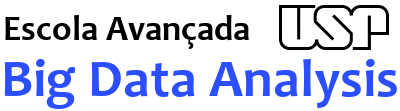

Conditional Generative Adversarial Network - CIFAR 10

In [ ]:
!pip uninstall tensorflow keras tensorstore tf-keras orbax-checkpoint -y
!pip install keras==2.15.0 tensorflow==2.15.0

Conditional Guns

Fonte: https://github.com/bnsreenu/python_for_microscopists/blob/master/249_keras_implementation-of_conditional_GAN/249-cifar_conditional_GAN.py

![image.png](attachment:9f09f198-0f24-428e-acef-428cac2df646.png)

In [ ]:
# Bibliotecas
from numpy import asarray
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU

from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from matplotlib import pyplot as plt
from tensorflow import keras

import tensorflow as tf
import numpy as np

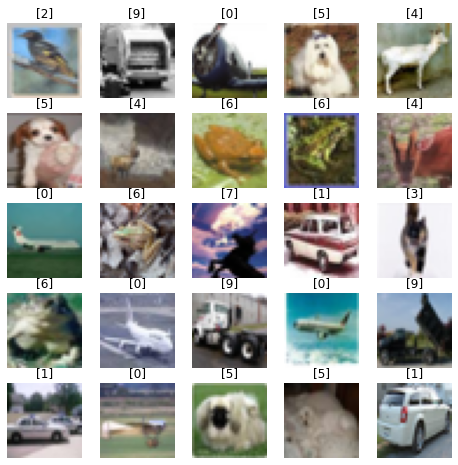

In [ ]:
# Conjunto de Dados CIFAR 10
# CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
plt.figure(figsize=(8,8))
for i in range(25):
    idx = randint(trainX.shape[0])
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(trainX[idx])
    plt.title(str(trainy[idx]))
plt.show()

In [ ]:
trainX.shape

(50000, 32, 32, 3)

In [ ]:
# Constroi o discriminador

# Diferente da GAN convencional, aqui também fornecemos o número de classes como entrada
# Assim, a entrada do modelo será as imagens e seus rótulos
def constroi_discriminador(in_shape=(32,32,3), n_classes=10):

    # Entrada da classe
    in_label = Input(shape=(1,))  # Shape 1

    # Embedding para uma entrada categórica
    # Cada classe (10 para o cifar10) será representada por um vetor de tamanho 50
    # Esse vetor de tamanho 50 será aprendido pelo discriminador
    # n_classes: tamanho do vocabulário. in_label é valor entre 0 e 9
    li = Embedding(n_classes, 50)(in_label) # Shape 1,50

    # Cria uma camada densa para redimensionar o vetor de embedding para a dimensão da imagem de entrada
    n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024.
    li = Dense(n_nodes)(li)  #Shape = 1, 1024

    # Inclui um canal adicional. Vamos fazer isso para depois poder concatenar com a imagem de entrada
    li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1

    # Entrada da imagem
    in_image = Input(shape=in_shape) #32x32x3

    # Concatena a classe como um canal a mais
    merge = Concatenate()([in_image, li]) #32x32x4 (4 canais, 3 para a imagem e 1 para a classe)

    # A partir daqui a estrutura é a mesma da GAN convencional
    # A imagem de entrada, combinada com a classe, é fornecida como entrada para camadas de convolução
    # 128 filtros
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
    fe = LeakyReLU(alpha=0.2)(fe)

    # 128 filtros
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
    fe = LeakyReLU(alpha=0.2)(fe)

    # Flatten
    fe = Flatten()(fe)  #8192  (8*8*128=8192)

    # Dropout
    fe = Dropout(0.4)(fe)

    # Saída - um único neurônio
    out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1

    # Contrói o modelo completo
    # Combina o rótulo de entrada com a imagem de entrada e forneçe como entradas para o modelo.
    model = Model([in_image, in_label], out_layer)

    # Compila o modelo
    opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [ ]:
(trainX, trainy), (_, _) = load_data()   #cifar
print(trainy[1:8])
print(trainy[1])

[[9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]]
[9]


In [ ]:
li = Embedding(10, 50)(trainy[1])
li

2024-11-28 10:31:35.861977: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


<tf.Tensor: shape=(1, 50), dtype=float16, numpy=
array([[-0.0293  ,  0.04816 ,  0.000986,  0.0405  ,  0.0282  , -0.01184 ,
         0.0491  , -0.003365, -0.01474 ,  0.02286 , -0.0366  ,  0.02159 ,
         0.04068 , -0.02614 ,  0.01267 , -0.03397 , -0.03177 ,  0.02657 ,
        -0.02226 , -0.04788 , -0.000635, -0.002832, -0.01472 ,  0.03226 ,
         0.006702, -0.0241  , -0.02542 ,  0.02576 ,  0.00606 , -0.01161 ,
         0.01462 , -0.01237 , -0.02132 ,  0.04135 , -0.015396, -0.02986 ,
         0.02667 ,  0.03748 , -0.01663 , -0.01251 ,  0.002542,  0.0401  ,
         0.04144 ,  0.01591 ,  0.01897 , -0.01391 ,  0.01228 ,  0.04605 ,
         0.04004 ,  0.01729 ]], dtype=float16)>

In [ ]:
# Controi o discriminador e mostra o sumário
discriminador = constroi_discriminador()
print(discriminador.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 1024)      52224       ['embedding_1[0][0]']            
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                              

Deconvolução (Convolução Transposta)

- Multiplica cada elemento na camada de entrada por cada valor no kernel

---------------------------------------------------------------------------------------------
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*eeMbMohZF-K3OsAlbiJBZA.png">

---------------------------------------------------------------------------------------------

- Combina todas as quatro camadas resultantes e soma os valores sobrepostos

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*qUZxyunJ_s4xxbgKcbwgmQ.png">

---------------------------------------------------------------------------------------------

Fonte: https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967


In [ ]:
# Constroi o gerador
def constroi_gerador(latent_dim, n_classes=10):

    # Entrada da classe
    in_label = Input(shape=(1,))  #Input of dimension 1

    # Embedding para uma entrada categórica
    # Cada classe (10 para o cifar10) será representada por um vetor de tamanho 50
    # n_classes: tamanho do vocabulário. in_label é valor entre 0 e 9
    li = Embedding(n_classes, 50)(in_label) #Shape 1,50

    # Dimensão inicial para geração da imagem
    # Vamos começar com 8x8 para depois aumentar até chegar em uma imagem de 32x32
    # Esse canal depois será concatenado com a imagem gerada
    n_nodes = 8 * 8
    li = Dense(n_nodes)(li) #1,64

    # # Inclui um canal adicional. Vamos fazer isso para depois poder concatenar com a imagem que será gerada
    li = Reshape((8, 8, 1))(li)

    # image generator input
    in_lat = Input(shape=(latent_dim,))  #Input of dimension 100

    # Assim como no discriminador, precisamos de uma dimensão inicial para gerar imagens
    # Vamos usar a dimensão 8x8 com essa finalidade. A camada densa que receberá como entrada o
    # vetor latente de ruído terá então 128x8x8 nós, para que possamos posteriormente redimensionar
    # para 8x8x128 (128 canais). Por meio de deconvoluções (convoluções transpostas) iremos redimensionar
    # as imagens até chegar na dimensão de saída 32x32

    # A partir daqui a estrutura é a mesma da GAN convencional até a saída
    # Ao definir as entradas do modelo, combinaremos o rótulo de entrada e a entrada latente (ruído)
    n_nodes = 128 * 8 * 8
    gen = Dense(n_nodes)(in_lat)  #shape=8192
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 128))(gen) #Shape=8x8x128

    # Concatena a imagen gerada (8x8x128) com a classe (8x8x1)
    merge = Concatenate()([gen, li])  #Shape=8x8x129 (Canal extra que corresponde à classe)

    # Deconvolução para 16x16
    # Calculo: output_size = strides * (input_size-1) + kernel_size - 2*padding
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
    gen = LeakyReLU(alpha=0.2)(gen)

    # Deconvolução para 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
    gen = LeakyReLU(alpha=0.2)(gen)

    # Saída
    out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3

    # controi o modelo
    model = Model([in_lat, in_label], out_layer)

    return model   # O modelo não foi compilado porque não é treinado diretamente como o discriminador.

In [ ]:
gerador = constroi_gerador(100, n_classes=10)
print(gerador.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 8192)         827392      ['input_4[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

In [ ]:
# Constroi a GAN

# O gerador é treinado via modelo combinado (GAN) de gerador e discriminador.
# Para atualizar o gerador, o discriminador é treinado separadamente, então aqui apenas o gerador será treinado mantendo
# o discriminador constante (congela os pesos do discriminador).

def constroi_gan(g_model, d_model):
    # O discriminador é treinado separadamente. Por isso congela os pesos do discriminador
    d_model.trainable = False

    # Conecta o gerador e o discriminador.
    # Primeiro, pegamos o ruído de entrada (vetor latente) e rótulo de entrada para o gerador
    gen_noise, gen_label = g_model.input

    # Pega a imagem de saída do gerador
    gen_output = g_model.output  #32x32x3

    # A imagem gerada pelo gerador e o rótulo correspondente são dados como entrada para o discriminador
    gan_output = d_model([gen_output, gen_label])

    # Define modelo GAN como pegando ruído e rótulo e emitindo uma classificação
    model = Model([gen_noise, gen_label], gan_output)

    # Compila o modelo combinado
    opt = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model

In [ ]:
gan = constroi_gan(gerador, discriminador)
print(gan.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 8192)         827392      ['input_4[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

In [ ]:
# Função para carregar os dados da CIFAR10
def carrega_dataset():
    # carrega dataset
    (trainX, trainy), (_, _) = load_data()   #cifar

    # converte para floats e normaliza
    X = trainX.astype('float32')

    # normaliza de [0,255] pata [-1,1]
    X = (X - 127.5) / 127.5
    # O gerador usa ativação tanh, então redimensionamos as imagens
    # originais de -1 para 1 para corresponder à saída do gerador.

    return [X, trainy]

In [ ]:
# Selecionar amostras reais
# Escolher um lote de amostras reais aleatórias para treinar a GAN
# Treinaremos a GAN em meio lote de imagens reais e outro meio lote de imagens falsas.
# Para cada imagem real atribuímos um rótulo 1, e para falsa atribuímos um rótulo 0.

def gera_amostras_reais(dataset, n_samples):
    # Pega iamgens e rótulos
    images, labels = dataset

    # Seleciona imagens aleatóriamente
    ix = randint(0, images.shape[0], n_samples)

    # Seleciona imagens e rótulos de acordo com os índices ix aleatórios
    X, labels = images[ix], labels[ix]

    # gerar rótulos de classe e atribuir a y (não confunda isso com os rótulos acima que correspondem aos rótulos cifar)
    y = ones((n_samples, 1))  #Label=1 indica que as imagens são reais

    return [X, labels], y

In [ ]:
# Gera vetor latente para o gerador
def gera_vetores_latentes(latent_dim, n_samples, n_classes=10):
    # Gera pontos no espaço latente
    x_input = randn(latent_dim * n_samples)

    # Reshape em um lote de entradas para a rede
    z_input = x_input.reshape(n_samples, latent_dim)

    # Gera os rótulos
    labels = randint(0, n_classes, n_samples)

    return [z_input, labels]

In [ ]:
# Usa o gerador para gerar n exemplos falsos, com rótulos de classe.
# Forneça ao gerador latent_dim e número de amostras como entrada.
# Usa o gerador de pontos latentes acima para gerar pontos latentes.
def gera_amostras_falsas(gerador, latent_dim, n_samples):
    # Gera pontos no espaço latente
    z_input, labels_input = gera_vetores_latentes(latent_dim, n_samples)

    # geração de imagens
    images = gerador.predict([z_input, labels_input])

    # Rotula como falsos
    y = zeros((n_samples, 1))  #Label=0 indica imagens falsas

    return [images, labels_input], y

In [ ]:
n_batch = 256
bat_per_epo = int(50000 / n_batch)
print(bat_per_epo)
half_batch = int(n_batch / 2)
print(half_batch)

195
128


In [ ]:
# Treino do gerador e do discriminador

# Treina o gerador e o discriminador
# Fazemos um loop por várias épocas para treinar nosso Discriminador, selecionando primeiro
# um lote aleatório de imagens do nosso conjunto de dados verdadeiro.
# Então, geramos um conjunto de imagens usando o gerador.
# Passe ambos os conjuntos de imagens no Discriminador.
# Calcule os erros para as imagens verdadeiras e falsas e também para o modelo combinado.

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100,
          n_batch=4096, save_interval=100):

    # O modelo discriminador é atualizado para meio batch de amostras reais
    # e meio lote de amostras falsas, combinadas em um único batch.
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # Para cada época
    for i in range(n_epochs):
        # batches por época
        for j in range(bat_per_epo):

            # Treina o discriminador em imagens reais e falsas, separadamente (meio batch cada)
            # Pesquisas mostrou que o treinamento separado é mais eficaz.
            # Obter amostras reais selecionadas aleatoriamente
            [X_real, labels_real], y_real = gera_amostras_reais(dataset, half_batch)

            # Atualiza os pesos do discriminador com amostras reais
            # train_on_batch permite atualização em um batch específico
            d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

            # Gera amostras falsas
            [X_fake, labels], y_fake = gera_amostras_falsas(g_model, latent_dim, half_batch)

            # Atualiza os pesos do discriminador com amostras falsas
            d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            # Pega pontos no espaço latente (ruído) para dar de entrada para o gerador
            [z_input, labels_input] = gera_vetores_latentes(latent_dim, n_batch)


            # O gerador quer que o discriminador classifique as amostras geradas como reais (1)
            # É aqui que o gerador está tentando enganar o discriminador para acreditar que
            # a imagem gerada é verdadeira (portanto, valor de 1 para y)
            y_gan = ones((n_batch, 1))

            # Generator is part of combined model where it got directly linked with the discriminator
            # Train the generator with latent_dim as x and 1 as y.
            # Again, 1 as the output as it is adversarial and if generator did a great
            # job of folling the discriminator then the output would be 1 (true)
            # update the generator via the discriminator's error

            # O modelo combinado conecta o gerador diretamente ao discriminador
            # Treina o gerado com vetores latentes e y = 1 como saída (enganar o discriminador)
            # Atualiza os pesos do gerador por meio do erro do discriminador
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

            # Imprime os erros nesse batch
            print('Epoch>%d, Batch>%d/%d, Erro Discriminador (Reais)=%.3f, Erro Discriminador (Falsas)=%.3f Erro Gerador=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

            # Salva imagens geradas
            if i % save_interval == 0:
                save_imgs(i)

    # Salva o gerador
    g_model.save("cifar10_conditional_generator_%d_epochs.h5" % n_epochs)

In [ ]:
latent_points, labels = gera_vetores_latentes(10, 5)
print(latent_points)
print(labels)

[[ 1.23976245 -1.40315213 -1.35236271  0.77632976 -2.11210397  0.14358511
  -0.02905491  1.02403558 -1.18572651  0.12564159]
 [-3.22139141 -0.64443832 -1.39480825 -1.24570996 -0.48046847 -2.4482357
  -0.58668511 -0.35600651  0.35651924 -0.1500686 ]
 [ 0.04735249  0.43863672 -1.52276254 -1.06609603 -1.15045641  1.84519724
  -0.97372904  0.27379657  0.05640731  0.59449655]
 [-0.90696096  1.70201429 -0.31580122 -0.46108648  1.43541698  0.06824754
  -1.3925567   0.46681295 -1.37188192 -0.29846494]
 [-1.07397639  1.26859662  1.22577375 -0.21792003  0.624909   -0.33438734
   0.6167101  -0.91538026 -0.4024273   1.22281868]]
[7 5 5 7 2]


In [ ]:
labels = asarray([x for _ in range(10) for x in range(10)])
labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
def save_imgs(epoch):

    # Gera pontos para o gerador
    latent_points, labels = gera_vetores_latentes(100, 100)  #Latent dim and n_samples

    # Especifica rótulos - gera 10 conjuntos de rótulos, cada um indo de 0 a 9
    # Para mostrar o mesmo tipo de imagem em cada coluna
    labels = asarray([x for _ in range(10) for x in range(10)])

    # Gera as imagens
    X = g_model.predict([latent_points, labels])

    # Passa de [-1,1] para [0,1]
    X = (X + 1) / 2.0

    # Retorno para [0,255]
    X = (X*255).astype(np.uint8)

    # Plota as imagens
    plt.figure(figsize=(10,10))

    for i in range(100):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i, :, :, :])

    # Salva o grid de imagens
    plt.savefig("images_cgan_cifar10/cifar10_%d.png" % epoch)
    plt.close()

In [ ]:
# Treinamento da CGAN

# Tamanho do espaço latente
latent_dim = 100

# Cria o discriminador
d_model = constroi_discriminador()

# Cria o gerador
g_model = constroi_gerador(latent_dim)

# Cria a GAN (modelo combinado)
gan_model = constroi_gan(g_model, d_model)

# Carrega as imagens
dataset = carrega_dataset()

# Treina o modelo
!mkdir /content/images_cgan_cifar10/
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000000, n_batch=4096)

Epoch>1, Batch>1/12, Erro Discriminador (Reais)=0.683, Erro Discriminador (Falsas)=0.696 Erro Gerador=0.691
Epoch>1, Batch>2/12, Erro Discriminador (Reais)=0.618, Erro Discriminador (Falsas)=0.704 Erro Gerador=0.683
Epoch>1, Batch>3/12, Erro Discriminador (Reais)=0.563, Erro Discriminador (Falsas)=0.718 Erro Gerador=0.671
Epoch>1, Batch>4/12, Erro Discriminador (Reais)=0.510, Erro Discriminador (Falsas)=0.739 Erro Gerador=0.654
Epoch>1, Batch>5/12, Erro Discriminador (Reais)=0.461, Erro Discriminador (Falsas)=0.767 Erro Gerador=0.635
Epoch>1, Batch>6/12, Erro Discriminador (Reais)=0.413, Erro Discriminador (Falsas)=0.795 Erro Gerador=0.624
Epoch>1, Batch>7/12, Erro Discriminador (Reais)=0.371, Erro Discriminador (Falsas)=0.810 Erro Gerador=0.629
Epoch>1, Batch>8/12, Erro Discriminador (Reais)=0.338, Erro Discriminador (Falsas)=0.792 Erro Gerador=0.663
Epoch>1, Batch>9/12, Erro Discriminador (Reais)=0.310, Erro Discriminador (Falsas)=0.744 Erro Gerador=0.718
Epoch>1, Batch>10/12, Erro D